### Hands-on Practice: Implementing a GCN on the Karate Club Dataset

**Objective**: In this session, you'll work with a variant of the Karate Club dataset, featuring 4 classes, to implement a Graph Convolutional Network (GCN) using PyTorch Geometric.

### About the Karate Club Dataset (4 Classes):
The Karate Club dataset represents the social interactions between 34 members of a university karate club. Originally, the dataset is famous for showing how the club eventually split into two factions due to a conflict between the club’s instructor and administrator. However, in this version, the dataset is partitioned into **4 distinct classes**, representing finer subdivisions of the members based on their community structure within the club.

### Dataset Structure:
- **34 nodes**: Each node corresponds to a club member.
- **78 edges**: Edges represent friendships between members based on social interactions.
- **4 classes**: The nodes are classified into 4 distinct communities, which reflect a more detailed subdivision of the original two factions.

In [114]:
import torch
from torch_geometric.datasets import KarateClub
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.optim as optim

##### Task 1: 
- Load the dataset
- Print Basic Dataset Information: 
    - Number of features
    - Number of classes
- Answer the following about the graph structure:
    - Does it contain isolated nodes?
    - Does it contain self-loops?
    - Is it undirected?
    - Number of nodes in the graph
    - Number of edges in the graph
    - Averagte node degrees

In [115]:
dataset = KarateClub()
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of features: 34
Number of classes: 4
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


##### Task 2:

visualize the Karate Club dataset using NetworkX, focusing on how nodes (members) are connected and colored by their community or faction.

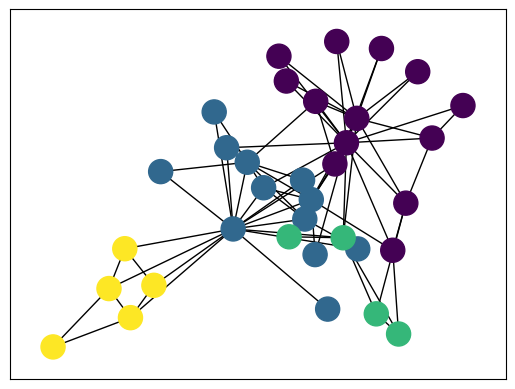

In [116]:
G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G,
                 pos=nx.spring_layout(G),
                 with_labels=False,
                 node_color=data.y)
plt.show()

##### Task 3:

implement a Graph Convolutional Network (GCN) using PyTorch. This GCN will be designed to process the Karate Club dataset for node classification.

In [117]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()  
        out = self.classifier(h)

        return out, h
    
model = GCN(dataset.num_features, 4, dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (classifier): Linear(in_features=4, out_features=4, bias=True)
)


##### Task 4:
Implement the training procedure for the Graph Convolutional Network (GCN) on the Karate Club dataset. This involves defining a training function, initialize the loss function and optimizer, and running the training loop.

In [118]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
losses = []

In [119]:
def train(data, optimizer, model, criterion):
    model.train()
    optimizer.zero_grad()
    out, _ = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(150):
    loss = train(data, optimizer, model, criterion)  # Call the training function.
    losses.append(loss.item())  # Store the loss for this epoch.


##### Task 5: 

visualize the training loss of the Graph Convolutional Network (GCN) over the training epochs. This will help you assess the model's performance and convergence during training.

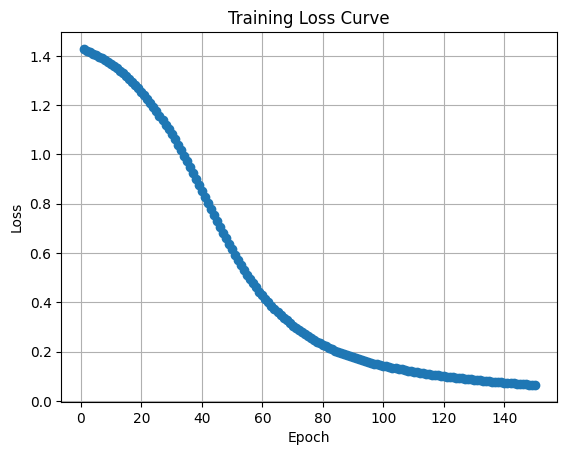

In [120]:
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

##### Task 6: 

Visualize the node embeddings generated by the Graph Convolutional Network (GCN) using t-SNE, helping you understand how the GCN captures relationships within the Karate Club dataset.

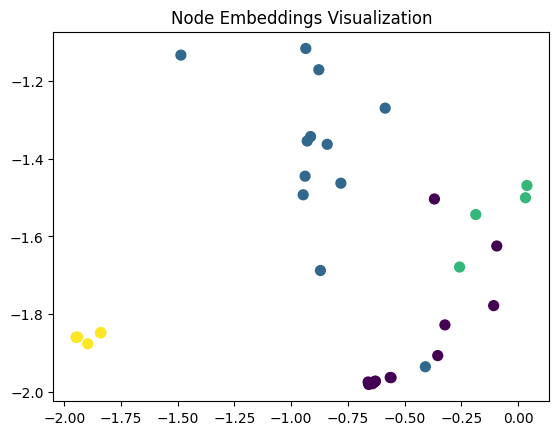

In [121]:
data = dataset[0]
with torch.no_grad():
    out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()
# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)
# Create a scatter plot to visualize the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y, cmap='viridis', s=50)
plt.title("Node Embeddings Visualization")
plt.show()